In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

In [ ]:
# Mount gdrive folders on this colab session
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
checkpoint_path = '/content/drive/MyDrive/dev/mnist-transformer/checkpoint-mnist/'

In [ ]:
# Carica il dataset MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0  # Normalizza le immagini
x_test = x_test / 255.0

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Aggiunge una dimensione ai dati per compatibilità con TensorFlow
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Convertiamo le etichette in int32
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

In [ ]:
# Transformer Encoder Layer
class TransformerEncoder(layers.Layer):
    def __init__(self, latent_dim, num_heads):
        super(TransformerEncoder, self).__init__()
        self.self_attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=latent_dim) #self attention layer
        self.ffn = tf.keras.Sequential([                                                         #feed-forward layer
            layers.Dense(latent_dim * 2, activation='relu'),
            layers.Dense(latent_dim)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        attn_output = self.self_attention(inputs, inputs)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        return self.layernorm2(out1 + ffn_output)


In [ ]:
# Transformer Decoder Layer
class TransformerDecoder(layers.Layer):
    def __init__(self, latent_dim, num_heads):
        super(TransformerDecoder, self).__init__()
        self.self_attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=latent_dim)                #self attention layer
        self.encoder_decoder_attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=latent_dim)     #encoder_decoder attention layer
        self.ffn = tf.keras.Sequential([                                                                        #feed-forward layer
            layers.Dense(latent_dim * 2, activation='relu'),
            layers.Dense(latent_dim)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs, encoder_output):
        attn1 = self.self_attention(inputs, inputs)
        out1 = self.layernorm1(inputs + attn1)
        out1 = self.layernorm1(inputs)
        attn2 = self.encoder_decoder_attention(out1, encoder_output)
        out2 = self.layernorm2(out1 + attn2)
        ffn_output = self.ffn(out1)
        return self.layernorm3(out1 + ffn_output)


In [ ]:
class ImageGenerator(tf.keras.Model):
    def __init__(self, num_classes=10, image_size=28, latent_dim=1, num_heads=2, num_layers=1):
        super(ImageGenerator, self).__init__()
        self.embedding = layers.Embedding(input_dim=num_classes, output_dim=latent_dim)
        self.encoders = [TransformerEncoder(latent_dim, num_heads) for _ in range(num_layers)]    #n layer per encoder
        self.decoders = [TransformerDecoder(latent_dim, num_heads) for _ in range(num_layers)]    #n layer per decoder
        self.output_layer = layers.Dense(image_size * image_size, activation='sigmoid')

    def call(self, inputs):
        x = self.embedding(inputs)
        x = tf.expand_dims(x, axis=1)
        '''
        for encoder in self.encoders:
            y = encoder(x)
            '''
        for decoder in self.decoders:
            x = decoder(x, x)
        x = self.output_layer(x)
        return tf.reshape(x, [-1, 28, 28])

In [ ]:
#Build del modello, loss function e optimizer
model = ImageGenerator()
loss_function = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam()


In [ ]:
# Prepara i dati per il training
x_train = np.expand_dims(x_train, -1)  # Aggiungi una dimensione per il canale
x_test = np.expand_dims(x_test, -1)

y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

In [ ]:
EPOCHS_TOT = 0
MODEL_NAME = 'model_decoder_no_attention_d1l1'

In [ ]:
# Parametri di training
epochs = 1
batch_size = 16
train_dataset = tf.data.Dataset.from_tensor_slices((y_train, x_train)).shuffle(10000).batch(batch_size)


# Loop di training manuale
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    total_loss = 0
    num_batches = 0

    for step, (digit, real_image) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            generated_image = model(digit)  # Forward pass
            real_image = tf.squeeze(real_image)
            loss = loss_function(real_image, generated_image)  # Calcolo della loss

        # Backpropagation
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        total_loss += loss.numpy()
        num_batches += 1

        if step % 100 == 0: #print statistiche ogni 100 batch
            print(f"Step {step}, Loss: {loss.numpy():.4f}")

    avg_loss = total_loss / num_batches
    print(f"Epoch {epoch+1} completed. Average Loss: {avg_loss:.4f}")
    EPOCHS_TOT += 1
    path = checkpoint_path + f'{MODEL_NAME}_{str(EPOCHS_TOT)}.keras'
    model.save(path)


Epoch 1/1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'transformer_decoder_10', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Step 0, Loss: 0.6931
Step 100, Loss: 0.6514
Step 200, Loss: 0.5986
Step 300, Loss: 0.5407
Step 400, Loss: 0.4871
Step 500, Loss: 0.4383
Step 600, Loss: 0.3736
Step 700, Loss: 0.3712
Step 800, Loss: 0.3452
Step 900, Loss: 0.3315
Step 1000, Loss: 0.2999
Step 1100, Loss: 0.2977
Step 1200, Loss: 0.3116
Step 1300, Loss: 0.2975
Step 1400, Loss: 0.2784
Step 1500, Loss: 0.2645
Step 1600, Loss: 0.2944
Step 1700, Loss: 0.2838
Step 1800, Loss: 0.2669
Step 1900, Loss: 0.2600
Step 2000, Loss: 0.2675
Step 2100, Loss: 0.2503
Step 2200, Loss: 0.2806
Step 2300, Loss: 0.2697
Step 2400, Loss: 0.2782
Step 2500, Loss: 0.2781
Step 2600, Loss: 0.2637
Step 2700, Loss: 0.2777
Step 2800, Loss: 0.2517
Step 2900, Loss: 0.2737
Step 3000, Loss: 0.2641
Step 3100, Loss: 0.2691
Step 3200, Loss: 0.2431
Step 3300, Loss: 0.2626
Step 3400, Loss: 0.2850
Step 3500, Loss: 0.2754
Step 3600, Loss: 0.2849
Step 3700, Loss: 0.2689
Epoch 1 completed. Average Loss: 0.3242


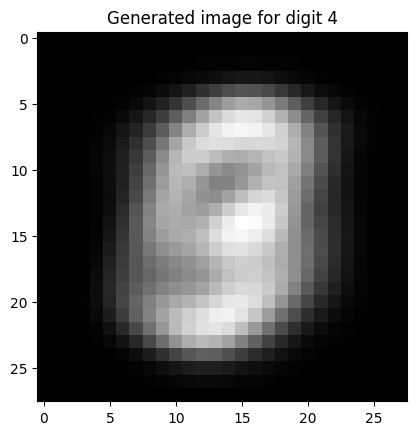

In [ ]:
def generate_image(model, digit):
    input_digit = np.array([digit])
    image = model(input_digit)
    plt.imshow(image[0], cmap='gray')
    plt.title(f"Generated image for digit {digit}")
    plt.show()

# Carica il modello e genera immagine
x = model(np.array([0])) #chiamo il modello su un input a caso così viene costruito
model.load_weights(f'{checkpoint_path}{MODEL_NAME}.keras')
generate_image(model, 4)


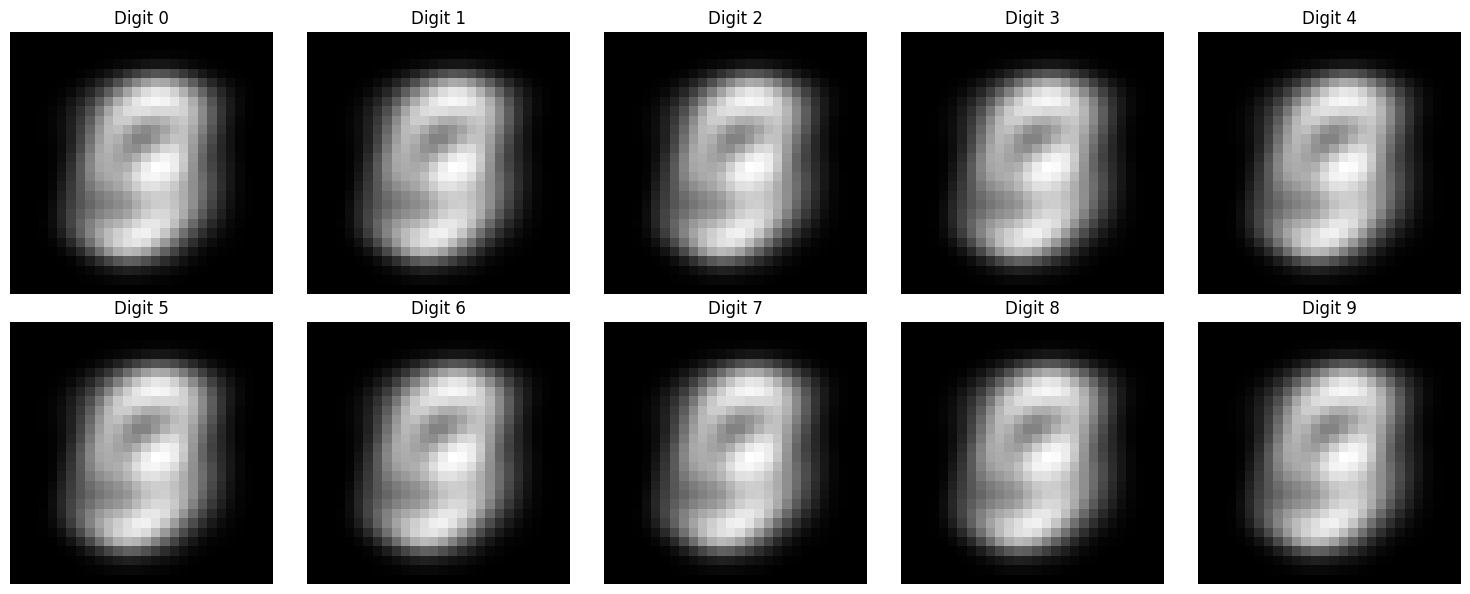

In [ ]:
import matplotlib.image as mpimg

# Crea una figura con 2 righe e 5 colonne
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
input_digit = np.array([0,1,2,3,4,5,6,7,8,9])
image = model(input_digit)

for i, ax in enumerate(axes.flat):
    ax.imshow(image[i], cmap='gray')
    ax.set_title(f"Digit {i}")  # Aggiungi il titolo con la cifra
    ax.axis('off')  # Disabilita gli assi

plt.tight_layout()
plt.show()

In [ ]:
# Valutazione del modello sul test set

loss_data = [0.0 for _ in range(10)]
loss_count = [0 for _ in range(10)]
total_loss = 0

for i in range(10000):
  digit = y_test[i]
  real_image = x_test[i]

  generated_image = model(np.array([digit]))  # Forward pass
  real_image = tf.squeeze(real_image)
  generated_image = tf.squeeze(generated_image)
  loss = loss_function(real_image, generated_image)  # Calcolo della loss

  loss_data[digit] += loss.numpy()
  loss_count[digit] += 1

'''
  if i % 100 == 0:
    for k in range(10):
      try:
        print(f"Loss for digit {k}: {loss_data[k]/loss_count[k]:.4f}")
      except:
        print(f"Loss for digit {k}: 0")
'''


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


'\n  if i % 100 == 0:\n    for k in range(10):\n      try:\n        print(f"Loss for digit {k}: {loss_data[k]/loss_count[k]:.4f}")\n      except:\n        print(f"Loss for digit {k}: 0")\n'

Loss for digit 0: 0.3308
Loss for digit 1: 0.1963
Loss for digit 2: 0.2958
Loss for digit 3: 0.2731
Loss for digit 4: 0.2525
Loss for digit 5: 0.2662
Loss for digit 6: 0.2809
Loss for digit 7: 0.2502
Loss for digit 8: 0.2635
Loss for digit 9: 0.2406
Average loss: 0.2639


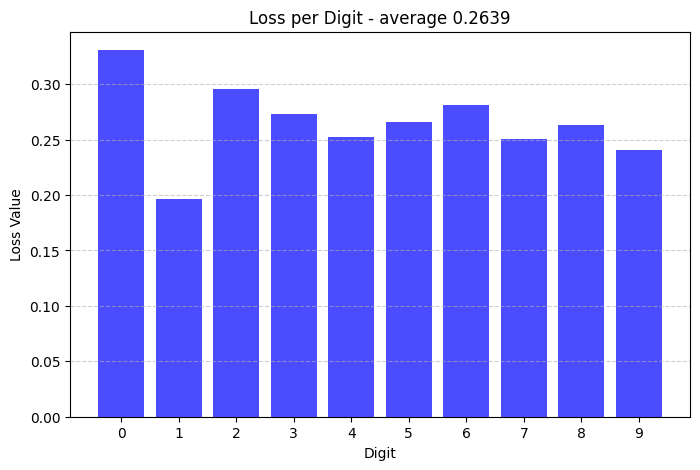

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

# Salvataggio su file
with open(f'/content/drive/MyDrive/dev/mnist-transformer/loss/loss_{MODEL_NAME}.txt', 'a') as f:
    f.write(f"Loss value for {MODEL_NAME}\n")

    loss_values = []
    digits = list(range(10))  # Cifre da 0 a 9

    for k in digits:
        loss = loss_data[k] / loss_count[k]
        loss_values.append(loss)
        print(f"Loss for digit {k}: {loss:.4f}")
        f.write(f"Loss for digit {k}: {loss:.4f}\n")

    tot = 0
    for k in range(10):
      tot += loss_data[k]
    print(f"Average loss: {tot / y_test.shape[0]:.4f}")
    f.write(f"Average loss: {tot / y_test.shape[0]:.4f}\n")

# Creazione dell'istogramma
plt.figure(figsize=(8, 5))
plt.bar(digits, loss_values, color='blue', alpha=0.7)
plt.xlabel("Digit")
plt.ylabel("Loss Value")
plt.title(f"Loss per Digit - average {tot / y_test.shape[0]:.4f}")
plt.xticks(digits)  # Etichette asse X
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Mostra il grafico
plt.show()
plt.savefig(f'/content/drive/MyDrive/dev/mnist-transformer/loss/loss_{MODEL_NAME}.png')
